In [1]:
!ls

0218-gpt2-add-normal.ipynb	    checkpoint.weights.h5
0218-gpt2.ipynb			    data
0219-gpt2-add-f1score.ipynb	    submission-add-normal.csv
0219-gpt2-add-normal-f1score.ipynb  submission.csv
checkpoint-add-normal.weights.h5    submission_integers.csv
checkpoint-f1score.weights.h5	    train_add_normal.csv


In [2]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
train_data_path ="~/aiffel/dktc/train_add_normal.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 4266


In [5]:
train_data.isnull().values.any()

False

In [6]:
train_data['conversation'].duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4261    False
4262    False
4263    False
4264    False
4265    False
Name: conversation, Length: 4266, dtype: bool

In [7]:
duplicated = train_data[train_data['conversation'].duplicated()]
duplicated

,idx,class,conversation
392,392,기타 괴롭힘 대화,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...
523,523,직장 내 괴롭힘 대화,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...
789,789,기타 괴롭힘 대화,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...
824,824,기타 괴롭힘 대화,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...
869,869,직장 내 괴롭힘 대화,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...
...,...,...,...
4044,4044,일반 대화,택배 왔다고 문자가 왔는데 안 보임\n어디로 보냈길래? 택배실 확인했어?\nㅇㅇ 갔...
4046,4046,일반 대화,출근했는데 갑자기 자리 바뀌어 있음\n헐 진짜? 너한테 말도 없이?\nㅇㅇ 그냥 앉...
4047,4047,일반 대화,오늘 지각할 뻔했어. 알람 안 들렸음\n너 어제 또 새벽까지 게임했냐?\nㅋㅋㅋ 들...
4048,4048,일반 대화,점심 먹고 뭐 할 거야?\n카페 가서 좀 쉬다가 들어갈까?\nㅇㅇ 좋지. 근데 어디...


In [8]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['conversation'], inplace=True)
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how='any')
print('훈련 데이터의 리뷰 수 :',len(train_data))

훈련 데이터의 리뷰 수 : 4130


In [9]:
label = {'협박 대화' : '00', '갈취 대화' : '01', '직장 내 괴롭힘 대화' :'02', '기타 괴롭힘 대화' : '03', '일반 대화' : '04'}
train_data['label'] = train_data['class'].map(label)

In [10]:
train_data['class'].value_counts()

기타 괴롭힘 대화      1011
갈취 대화           973
직장 내 괴롭힘 대화     970
협박 대화           892
일반 대화           284
Name: class, dtype: int64

In [11]:
train_data['label'].value_counts()

03    1011
01     973
02     970
00     892
04     284
Name: label, dtype: int64

In [12]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
train_data['length'] = train_data['conversation'].apply(len)

In [14]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    input_ids, data_labels = [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return input_ids, data_labels

In [15]:
max_idx = train_data['length'].idxmax()
temp = tokenizer.encode(train_data['conversation'][max_idx])
max_seq_len = len(temp)
print(f'max seq len : {max_seq_len}')

train_X, train_y = convert_examples_to_features(train_data['conversation'], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

max seq len : 404


100%|██████████| 4130/4130 [00:02<00:00, 1984.50it/s]


In [16]:
len(train_X), len(train_y)

(4130, 4130)

In [17]:
model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.1.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'lm_head.weight', 'transformer.h.7.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [18]:
import tensorflow as tf
from transformers import TFGPT2Model

class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(TFGPT2ForSequenceClassification, self).__init__()
        
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        # 클래스 개수 저장
        self.num_labels = num_labels
        
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.dense = tf.keras.layers.Dense(128, activation="relu")
        self.classifier = tf.keras.layers.Dense(
            # 출력 뉴런 수 = 클래스 개수
            num_labels,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
            # 다중 클래스 분류이므로 softmax 사용
            activation='softmax',
            name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        # 마지막 토큰 가져오기
        cls_token = outputs[0][:, -1]
        cls_token = self.dropout(cls_token)
        cls_token = self.dense(cls_token)
        cls_token = self.dropout(cls_token)
        prediction = self.classifier(cls_token)

        return prediction

In [19]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Wed Feb 19 05:57:25 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T

In [20]:
from tensorflow.keras.utils import to_categorical

train_y_one_hot = to_categorical(train_y, num_classes=5)
len(train_y_one_hot), train_y_one_hot

(4130,
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]], dtype=float32))

In [21]:
strategy = tf.distribute.MirroredStrategy() if tf.config.list_physical_devices('GPU') else tf.distribute.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa

checkpoint_path = os.getenv('HOME')+'/aiffel/dktc/checkpoint-only-f1score.weights.h5'

with strategy.scope():
  model = TFGPT2ForSequenceClassification(model_name="skt/kogpt2-base-v2", num_labels=5)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  # from_logits=False (Softmax 출력)
  # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

  es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
  mc = ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_loss', save_best_only=True, verbose=1)

  f1 = tfa.metrics.F1Score(num_classes=5, average="macro")

  model.compile(optimizer=optimizer, loss=loss, metrics = [f1])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.1.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'lm_head.weight', 'transformer.h.7.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
history = model.fit(train_X, train_y_one_hot, epochs=10, batch_size=8, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
413/413 [==============================] - 359s 834ms/step - loss: 0.9193 - f1_score: 0.4966 - val_loss: 2.6695 - val_f1_score: 0.5147

Epoch 00001: val_loss improved from inf to 2.66953, saving model to /aiffel/aiffel/dktc/checkpoint-only-f1score.weights.h5
Epoch 2/10
413/413 [==============================] - 344s 833ms/step - loss: 0.4521 - f1_score: 0.6799 - val_loss: 3.0294 - val_f1_score: 0.5089

Epoch 00002: val_loss did not improve from 2.66953
Epoch 3/10
413/413 [==============================] - 344s 833ms/step - loss: 0.2998 - f1_score: 0.7208 - val_loss: 3.5971 - val_f1_score: 0.5560

Epoch 00003: val_loss did not improve from 2.66953
Epoch 00003: early stopping


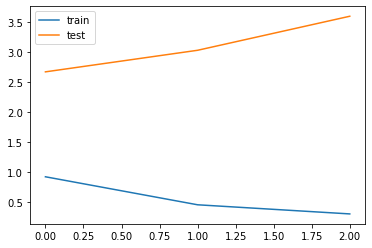

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [25]:
import pandas as pd
import json

test_json_path = os.getenv('HOME')+'/aiffel/dktc/data/test.json'

# JSON 파일 불러오기
with open(test_json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 변환: key를 인덱스로 하고, 내부 "text" 값을 컬럼으로 변환
test_data = pd.DataFrame.from_dict(data, orient="index")
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [26]:
model.load_weights(checkpoint_path)

def classify(sentence):
  bos_token = [tokenizer.bos_token]
  eos_token = [tokenizer.eos_token]

  tokens = bos_token + tokenizer.tokenize(sentence) + eos_token
  input_id = tokenizer.convert_tokens_to_ids(tokens)

  input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]
  input_id = np.array([input_id])

  scores = model.predict(input_id)[0]
  # 가장 높은 확률을 가진 클래스 선택
  predicted_class = np.argmax(scores)
  confidence = np.max(scores) * 100

  return predicted_class

In [27]:
test_data['text'][3]

'이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 음 난 좀 별론데 좋을 줄 알았는데 아쉽네 내 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래'

In [28]:
classify(test_data['text'][3])

3

In [29]:
test_data['target'] = test_data['text'].apply(classify)
test_data.head()

,text,target
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,1
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,2
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,3
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,3
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,1


In [30]:
output_df = test_data[['target']].reset_index()
output_df.rename(columns={'index': 'idx'}, inplace=True)

output_df.head()

,idx,target
0,t_000,1
1,t_001,2
2,t_002,3
3,t_003,3
4,t_004,1


In [31]:
csv_path = os.getenv('HOME')+'/aiffel/dktc/submission-only-f1score.csv'
output_df.to_csv(csv_path, index=False)